In [65]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('../data/mvp_data.csv', parse_dates=True, index_col=0)
df.columns = ['EUR', 'GOLD', 'Bitcoin', 'Apple', 'Exxon', 'VISA', 'Oil']
# заполним пропуски последними известными значениями, так как пропуски чаще всего - это праздничные периоды
# перейдем на недельный интервал и средним значениям на них
df_w = df.fillna(method='ffill').resample('W').ffill()
df_w_pct = df_w.pct_change().iloc[1:] # отнсительные изменения к предыдущей неделе
df_w_pct.head()

,EUR,GOLD,Bitcoin,Apple,Exxon,VISA,Oil
Date,,,,,,,
2020-01-12,-0.005400,0.005358,0.111870,0.043372,-0.016920,0.021994,-0.063600
2020-01-19,0.002562,0.000835,0.093367,0.027068,-0.008389,0.056407,-0.008469
2020-01-26,-0.007573,0.007891,-0.054161,-0.001318,-0.032672,0.001466,-0.074308
2020-02-02,-0.002360,0.007511,0.107170,-0.027646,-0.063329,-0.029415,-0.048533
2020-02-09,-0.004185,-0.009034,0.047635,0.036443,-0.010464,0.018948,-0.024050


<AxesSubplot:xlabel='Date'>

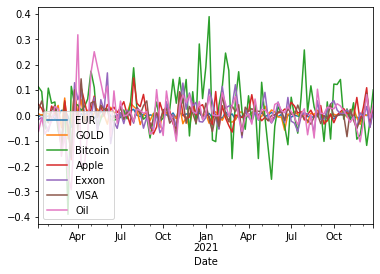

In [10]:
train_df = df_w_pct[:'2021-12-31'] # TRAIN 2020-2021
test_df = df_w_pct['2022-01-01':] # TEST 2022
train_df.plot()

In [57]:
# средняя доходность по каждому активу
gainMean = train_df.mean()
gainMean

EUR        0.000192
GOLD       0.001844
Bitcoin    0.024771
Apple      0.009594
Exxon      0.001586
VISA       0.002349
Oil        0.005079
dtype: float64

In [12]:
# ковариационная матрица для расчета риска потрфеля (в диаогонали дисперсия)
covMatrix = train_df.cov()
covMatrix

,EUR,GOLD,Bitcoin,Apple,Exxon,VISA,Oil
EUR,0.000117,0.000099,0.000124,0.000159,0.000120,0.000160,0.000121
GOLD,0.000099,0.000657,0.000572,0.000382,0.000161,0.000369,0.000169
Bitcoin,0.000124,0.000572,0.011579,0.000495,0.001668,0.000406,0.002064
Apple,0.000159,0.000382,0.000495,0.002073,0.000692,0.001138,0.000764
Exxon,0.000120,0.000161,0.001668,0.000692,0.003281,0.001287,0.002590
VISA,0.000160,0.000369,0.000406,0.001138,0.001287,0.001863,0.001240
Oil,0.000121,0.000169,0.002064,0.000764,0.002590,0.001240,0.007037


## ФУНКЦИИ

In [55]:
# функция генерации случайного портфеля, где сумма долей активов равна 1

numAssets = len(train_df.columns)

def RNDportf():
    res = np.exp(np.random.randn(numAssets))
    res = res / res.sum()
    return res

portf = RNDportf()
print(portf)
print(portf.sum())

[0.01632204 0.6324253  0.05400813 0.05801563 0.02568716 0.19564016
 0.01790158]
1.0


In [62]:
# функция расчета доходности портфеля
def GAINportf(portf):
    return np.matmul(gainMean.values, portf)

portf = RNDportf()
print(portf)

print("Доходность портфеля:", GAINportf(portf))
print("Доходность при равных долях:", gainMean.mean())

[0.22921468 0.12578214 0.34549188 0.03216062 0.16532448 0.05574336
 0.04628284]
Доходность портфеля: 0.009770967043847428
Доходность при равных долях: 0.006487863860845928


In [59]:
gainMean.mean()

0.006487863860845928

In [72]:
# риск портфеля - корень из дисперсии,
# которую получаем через матричное произведение долей портфеля и матрицы ковариации (источник?)

def RISKportf(portf):
    return np.sqrt(np.matmul(np.matmul(portf, covMatrix.values), portf))

portf = RNDportf()
print(portf)
print(RISKportf(portf))

[0.25453537 0.10492515 0.0389917  0.08739744 0.26310629 0.21342575
 0.03761831]
0.028364025467321207


## ...

In [66]:
# генерация портфелей

iterNum = 1000

riskN = np.zeros(iterNum)
gainN = np.zeros(iterNum)
portfN = np.zeros((iterNum, numAssets))

for n in range(iterNum):
    portf = RNDportf()
    portfN[n, :] = portf
    riskN[n] = RISKportf(portf)
    gainN[n] = GAINportf(portf)

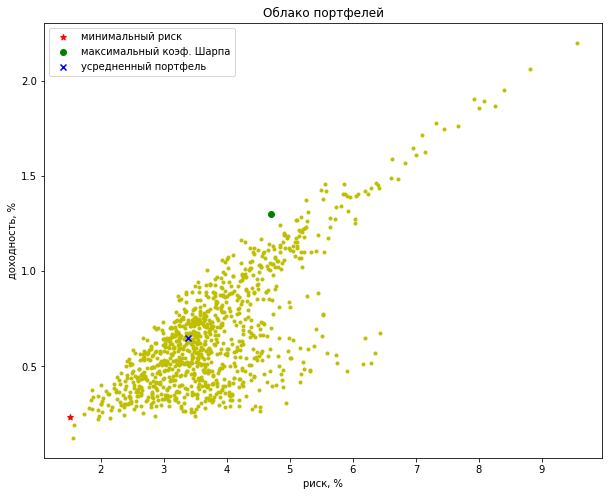

In [78]:
plt.figure(figsize=(10,8))

plt.scatter(riskN*100, gainN*100, c='y', marker='.')
plt.xlabel('риск, %')
plt.ylabel('доходность, %')
plt.title("Облако портфелей")

min_risk = np.argmin(riskN)
plt.scatter([(riskN[min_risk])*100],[(gainN[min_risk])*100],
            c='r', marker='*', label='минимальный риск')

maxSharpe = np.argmax(gainN/riskN)
plt.scatter([riskN[maxSharpe]*100], [gainN[maxSharpe]*100],
            c='g', marker='o', label='максимальный коэф. Шарпа')

portf_mean = np.ones(numAssets)/numAssets
risk_mean = RISKportf(portf_mean)
gain_mean = GAINportf(portf_mean)
plt.scatter([risk_mean*100], [gain_mean*100], c='b', marker='x', label='усредненный портфель')

plt.legend()

plt.show()

In [80]:
riskN[min_risk]

0.015076812529541541

In [81]:
gainN[min_risk]

0.0023435699046514633

In [84]:
print('---------- Минимальный риск ----------')
print()
print("риск = %1.2f%%" % (float(riskN[min_risk])*100.))
print("доходность = %1.2f%%" % (float(gainN[min_risk])*100.)) 
print()
print(pd.DataFrame([portfN[min_risk]*100], columns=train_df.columns, index=['доли, %']).T)
print()

print('---------- Максимальный коэффициент Шарпа ----------')
print()
print("риск = %1.2f%%" % (float(riskN[maxSharpe])*100.))
print("доходность = %1.2f%%" % (float(gainN[maxSharpe])*100.)) 
print()
print(pd.DataFrame([portfN[maxSharpe]*100],columns=train_df.columns, index=['доли, %']).T)
print()


---------- Минимальный риск ----------

риск = 1.51%
доходность = 0.23%

           доли, %
EUR      59.711013
GOLD     25.092641
Bitcoin   4.455123
Apple     4.019299
Exxon     1.155200
VISA      0.885976
Oil       4.680748

---------- Максимальный коэффициент Шарпа ----------

риск = 4.71%
доходность = 1.30%

           доли, %
EUR      14.020753
GOLD      4.869451
Bitcoin  36.979220
Apple    35.696800
Exxon     1.771214
VISA      2.510090
Oil       4.152472



In [85]:
print('---------- Средний портфель ----------')
print()
print("риск = %1.2f%%" % (float(risk_mean)*100.)) 
print("доходность = %1.2f%%" % (float(gain_mean)*100.)) 
print()
print(pd.DataFrame([portf_mean*100], columns=train_df.columns, index=['доли, %']).T)
print()

---------- Средний портфель ----------

риск = 3.39%
доходность = 0.65%

           доли, %
EUR      14.285714
GOLD     14.285714
Bitcoin  14.285714
Apple    14.285714
Exxon    14.285714
VISA     14.285714
Oil      14.285714

